# Compare SNOWPACK Output and SUMup Observations

This script will compare the output from the SNOWPACK model with observations from the SUMup density dataset for both the Greenland and Antarctica Ice Sheets.

All user-editable variables are listed in the cell below the library imports.

Required files that should be in the same directory:
1. ```sumup_density_2020_v060121.nc```
2. ```MERRA-2_Lat_Lon_SUMup_GNSS.txt```

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath
from cycler import cycler

# Set up plotting aesthetics
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 10
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.default'] = 'regular'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## User Input

In [2]:
# BEGIN

# Select the desired ice sheet to examine
# This script is designed to handle one ice sheet at a time so choose 'AIS' (Antarctica) or 'GrIS' (Greenland)
icesheet = 'GrIS'

# Select which grid points to plot. AIS: 1-272; GrIS: 273-416. 
points = np.arange(0,417) # Don't change this line
points = points[0:4] # Enter range of points here. Must do at least 2 points for plotting to work.
# To plot several non-consecutive points, comment out lines 8 and 9, and uncomment the below line
# points = [3,19,44,185,212]

# Enter directory for .pro and .smet files
path = '../snowpack/Scripts/Spinup/output/'

# Type 'y' (yes) or 'n' (no) to create plots
plot_density = 'n' # Individual density profiles (the more profiles, the longer it takes)
plot_fac = 'y' # Single firn air content plot

# END

## SUMup Data

Creates dataframe of corrected data (i.e., dates are fixed) and adds timestamps. Output is dataframe `df` with multi-index of `[CoreID,index]`. A given core can be extracted with the line `df.loc[<CoreID>]`.

Not all cores are shown because they are filtered to remove sea ice cores.

In [3]:
# Open dataset
sumup = xr.open_dataset('sumup_density_2020_v060121.nc')

# Extract data
su_citation = sumup['Citation'].values
su_date = sumup['Date'].values
su_lat = sumup['Latitude'].values
su_lon = sumup['Longitude'].values
su_depth0 = sumup['Start_Depth'].values
su_depth1 = sumup['Stop_Depth'].values
su_midpoint = sumup['Midpoint'].values
su_density = sumup['Density'].values
su_elev = sumup['Elevation'].values

# Some dates are just year (e.g., 'YYYY0000') so this will create a new column with Jan 1 of the year as the date
su_timestamp = []
for i in range(len(su_date)):
    d = su_date[i]
    date_str = str(d)
    
    # These particular dates appear to be very incorrect
    if date_str == '19999000.0':
        date_str = '19990000.0'
    if date_str == '20089620.0':
        date_str = '20080620.0'
    
    year = date_str[0:4]
    month = date_str[4:6]
    day = date_str[6:8]
    
    # Add Jan 1 to year-only dates, and change any with 32 days to 31 days
    if month == '00':
        month = '01'
    if day == '00':
        day = '01'
    if day == '32':
        day = '31'
    
    d = float(year+month+day)
    su_timestamp.append(d)
    
# Create SUMup dataframe
data_sumup = {'Citation':su_citation,'Timestamp':su_timestamp,'Latitude':su_lat,'Longitude':su_lon,
              'Elevation':su_elev,'Midpoint':su_midpoint,'StartDepth':su_depth0,'StopDepth':su_depth1,
              'Thickness':su_depth1-su_depth0,'Density':su_density*1000}
df = pd.DataFrame(data=data_sumup)

# Turn date into timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d')

# Create a unique index for each core
n = -1
id0 = []
for i in range(len(su_citation)-1):
    if (su_citation[i]==su_citation[i-1] and su_lat[i]==su_lat[i-1] and su_lon[i]==su_lon[i-1]):
        index = n
    else:
        n += 1
        index = n
    id0.append(index)
id0.append(id0[-1])

# Give each datapoint within a core index its own index
m = -1
id1 = []
for i in range(len(id0)-1):
    if id0[i] == id0[i-1]:
        m += 1
    else:
        m = 0
    id1.append(m)
id1.append(id1[-1]+1)

# Set indices in dataframe
df['CoreID'] = id0
df['CoreIdx'] = id1
idx0 = pd.Series(data=id0,name='Core')
idx1 = pd.Series(data=id1,name='Index')
idx_arrays = [idx0,idx1]
df.index = idx_arrays

# Remove sea ice and no data
df = df[(df.Elevation>0) & (df.Latitude>-91)]

df

Citation  Timestamp   Latitude   Longitude  Elevation  Midpoint  \
Core Index                                                                    
4    0           3.0 2011-12-28 -79.446800 -117.963501     1619.0     0.050   
     1           3.0 2011-12-28 -79.446800 -117.963501     1619.0     0.150   
     2           3.0 2011-12-28 -79.446800 -117.963501     1619.0     0.250   
     3           3.0 2011-12-28 -79.446800 -117.963501     1619.0     0.350   
     4           3.0 2011-12-28 -79.446800 -117.963501     1619.0     0.450   
...              ...        ...        ...         ...        ...       ...   
1324 5         187.0 2013-06-04  72.579781  -38.458630     3210.0     0.765   
     6         187.0 2013-06-04  72.579781  -38.458630     3210.0     0.795   
     7         187.0 2013-06-04  72.579781  -38.458630     3210.0     0.825   
     8         187.0 2013-06-04  72.579781  -38.458630     3210.0     0.855   
     9         187.0 2013-06-04  72.579781  -38.458630     3210.0     0.885   

            StartDepth  StopDepth  Thickness     Density  CoreID  CoreIdx  
Core Index                                                                 
4    0            0.00       0.10       0.10  368.000000       4        0  
     1            0.10       0.20       0.10  381.000000       4        1  
     2            0.20       0.30       0.10  368.000000       4        2  
     3            0.30       0.40       0.10  363.000000       4        3  
     4            0.40       0.50       0.10  389.000000       4        4  
...                ...        ...        ...         ...     ...      ...  
1324 5            0.75       0.78       0.03  274.000000    1324        5  
     6            0.78       0.81       0.03  297.699982    1324        6  
     7            0.81       0.84       0.03  308.000000    1324        7  
     8            0.84       0.87       0.03  305.599976    1324        8  
     9            0.87       0.90       0.03  326.299988    1324        9  

[2105892 rows x 12 columns]

## Metadata

Creates a dataframe of each unique SUMup location and corresponding MERRA-2 (SNOWPACK) location.

In [4]:
# Extract unqiue lat/lon from SUMup and save as new dataframe
df_sumuplocs = df[df.CoreIdx==0][['CoreID','Citation','Timestamp','Latitude','Longitude']]
df_sumuplocs = df_sumuplocs.reset_index(drop=True)

# Read in MERRA-2 location data
df_merra2locs = pd.read_table('MERRA-2_Lat_Lon_SUMup_GNSS.txt',
                       header=None,skiprows=1,sep=' ',names=['Latitude','Longitude'])
df_merra2locs['VIR'] = np.arange(1,len(df_merra2locs)+1)

# Haversine formula for calculating distance between two points on Earth
def haversine(lat1,lon1,lat2,lon2):
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    theta1 = np.deg2rad(lon1)
    theta2 = np.deg2rad(lon2)
    del_phi = phi2-phi1
    del_theta = theta2-theta1
    a = np.sin(del_phi/2)**2 + (np.cos(phi1)*np.cos(phi2)*np.sin(del_theta/2)**2)
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = (6371e3)*c # Earth's radius in meters
    return d # Meters

# Function for finding closest MERRA-2 location to given SUMup location
def closest_location(sumuplat,sumuplon):
    distance = []
    for i in range(len(df_merra2locs)):
        lat1 = sumuplat
        lon1 = sumuplon
        lat2 = df_merra2locs.Latitude[i]
        lon2 = df_merra2locs.Longitude[i]
        d = haversine(lat1,lon1,lat2,lon2)
        distance.append(d)
    p = np.where(distance == min(distance))
    return df_merra2locs.loc[p]

metadata = np.zeros((len(df_sumuplocs),7))
for i in range(len(df_sumuplocs)):
    metadata[i,0] = df_sumuplocs.CoreID[i]
    metadata[i,1] = np.array(df_sumuplocs.Timestamp)[i]
    metadata[i,2] = df_sumuplocs.Latitude[i]
    metadata[i,3] = df_sumuplocs.Longitude[i]
    merra2 = closest_location(df_sumuplocs.Latitude[i],df_sumuplocs.Longitude[i])
    metadata[i,4] = merra2.VIR.values[0]
    metadata[i,5] = merra2.Latitude.values[0]
    metadata[i,6] = merra2.Longitude.values[0]

# Create dataframe of metadata and turn float date back into timestamp
df_meta = pd.DataFrame(metadata,columns=['CoreID','Timestamp','SUMupLat','SUMupLon',
                                         'VIR','MERRALat','MERRALon'])
df_meta['Timestamp'] = pd.to_datetime(df_meta['Timestamp'])
df_meta

,CoreID,Timestamp,SUMupLat,SUMupLon,VIR,MERRALat,MERRALon
0,4.0,2011-12-28,-79.446800,-117.963501,93.0,-79.5,-118.125
1,5.0,2011-12-12,-79.347900,-116.290497,94.0,-79.5,-116.250
2,6.0,2011-12-24,-78.836899,-116.307098,105.0,-79.0,-116.250
3,7.0,2011-12-14,-78.727997,-114.732201,120.0,-78.5,-115.000
4,8.0,2011-12-20,-78.424301,-115.292000,120.0,-78.5,-115.000
...,...,...,...,...,...,...,...
1174,1295.0,2008-06-08,72.549934,-38.309067,339.0,72.5,-38.125
1175,1296.0,2008-06-16,72.579552,-38.505466,338.0,72.5,-38.750
1176,1297.0,2008-06-20,72.549934,-38.309067,339.0,72.5,-38.125
1177,1299.0,2013-06-04,72.635132,-38.514919,338.0,72.5,-38.750


## Plot locations

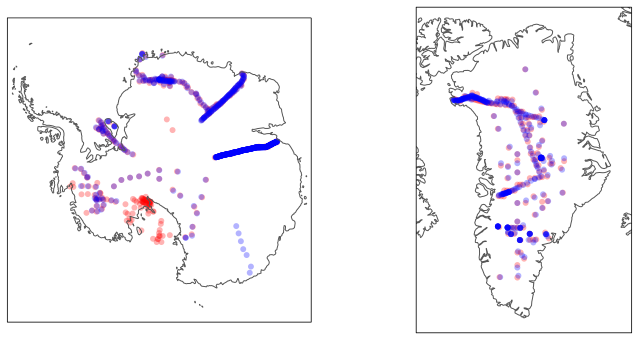

In [5]:
# Set up figure for plotting MERRA-2 locations
fig = plt.figure(figsize=(12,6))

# Antarctica
axAIS = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
axAIS.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
axAIS.coastlines(resolution='50m',color='#555555')
axAIS.scatter(df_merra2locs.Longitude,df_merra2locs.Latitude,transform=ccrs.PlateCarree(),
           color='r',alpha=0.3,edgecolors='none',label='MERRA-2 gridpoints\nat SUMup locations')
axAIS.scatter(df_sumuplocs.Longitude,df_sumuplocs.Latitude,transform=ccrs.PlateCarree(),
             color='b',alpha=0.3,edgecolors='none')

# Greenland
axGrIS = plt.subplot(1, 2, 2, projection=ccrs.NorthPolarStereo(central_longitude=-45))
axGrIS.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
axGrIS.coastlines(resolution='50m',color='#555555')
axGrIS.scatter(df_merra2locs.Longitude,df_merra2locs.Latitude,transform=ccrs.PlateCarree(),
           color='r',alpha=0.3,edgecolors='none',label='MERRA-2 gridpoints\nat SUMup locations')
axGrIS.scatter(df_sumuplocs.Longitude,df_sumuplocs.Latitude,transform=ccrs.PlateCarree(),
             color='b',alpha=0.3,edgecolors='none')

## Extract SNOWPACK Profile

Provide a SUMup core number and extract the corresponding SNOWPACK profile.

In [6]:
# Select cores from user input
if icesheet=='AIS':
    # Create new dataframe ignoring GrIS and any AIS points that were unsuccessful runs
    df_AIS = df_meta[(df_meta.VIR!=66)&(df_meta.VIR!=70)&(df_meta.VIR!=83)&(df_meta.VIR!=84)&(df_meta.VIR<273)]
    cores = df_AIS.CoreID.values # Get values of SUMup core IDs
    core = cores[points] # Get core IDs that correspond to user input
if icesheet=='GrIS':
    # Create new dataframe ignoring AIS and any GrIS points that were unsuccessful runs
    df_GrIS = df_meta[(df_meta.VIR!=382)&(df_meta.VIR!=303)&(df_meta.VIR!=304)&(df_meta.VIR!=289)&(df_meta.VIR>272)]
    cores = df_GrIS.CoreID.values # Get values of SUMup core IDs
    core = cores[points] # Get core IDs that correspond to user input

if plot_density == 'y':
    # Prepare figure and axes for plotting
    fig, ax = plt.subplots(1, len(core), figsize=(len(core)*3, 5))
    
# Empty lists for easier plotting
FAC_SU = []
FAC_SP = []
MAXdepth_SU = []
MAXdepth_SP = []
    
for i in range(len(core)):
    
    # Metadata for given core
    core_info = df_meta[df_meta.CoreID==core[i]]
    VIR = int(core_info.VIR) # Virtual station ID for SNOWPACK output

    # SUMup data
    df_SU = df.loc[core[i]]
    timestamp_SU = df_SU.Timestamp[0]
#     timestamp_SU = pd.to_datetime('2019-12-31 00:00:00') # Uncomment if you want very last SNOWPACK output
    
    # Calculate thicknesses; some have start/stop depths while others have single points
    if df_SU.StopDepth[0] == -9999:
        midpoint_SU = np.array(df_SU.Midpoint)
        thickness_SU = midpoint_SU[1:]-midpoint_SU[:-1]
        thickness_SU = np.insert(thickness_SU,0,midpoint_SU[0])
        maxdepth_SU = max(midpoint_SU)
        MAXdepth_SU.append(maxdepth_SU)
    else:
        thickness_SU = df_SU.Thickness
        maxdepth_SU = max(df_SU.StopDepth)
        MAXdepth_SU.append(maxdepth_SU)
        
    air_SU = (917-df_SU.Density) / 917
    fac_SU = np.sum(thickness_SU*air_SU) * (maxdepth_SU/np.sum(thickness_SU))
    FAC_SU.append(fac_SU)

    # VIR 1-272 are for the AIS, VIR 273-416 are for the GrIS
    if VIR < 273: # Antarctica
        file = path+'VIR'+str(VIR)+'_AIS.pro'
    else: # Greenland
        file = path+'VIR'+str(VIR)+'_GrIS.pro'

    # Open *.pro file and read in header (47 lines in length)
    f = open(file,'r')
    for j in range(47):
        header = f.readline()
        if j == 1:
            VIR_pro = int(header[29:-1])
        if j == 2:
            latitude_pro = float(header[10:-1])
        if j == 3:
            longitude_pro = float(header[11:-1])
        if j == 4:
            elevation_pro = float(header[9:-1])
#         print(header)

    timestamps_SP = [] # Empty list for storing timestamps

    # Read data line by line
    data = f.readlines()
    for line in data:
        linecode = line[0:4] # SNOWPACK gives each data type a 4-digit code

        # Extract timestamps and save in a list
        if linecode == '0500':
            raw_date_SP = line[5:24]
            date_SP = datetime.strptime(raw_date_SP,'%d.%m.%Y %H:%M:%S')
            timestamp_SP = pd.to_datetime(date_SP)
            timestamps_SP.append(timestamp_SP)

    # Find SNOWPACK timestamp that's closest to the desired SUMup one
    closest = min(timestamps_SP, key=lambda sub: abs(sub - timestamp_SU))
    k = np.where(np.array(timestamps_SP)==closest)[0][0]

    # Read data and extract lines corresponding to closest timestamp
    for line in data:
        linecode = line[0:4] # SNOWPACK gives each data type a 4-digit code

        if linecode == '0500':
            raw_date_SP = line[5:24]
            date_SP = datetime.strptime(raw_date_SP,'%d.%m.%Y %H:%M:%S')
            timestamp_SP = pd.to_datetime(date_SP)

            if timestamp_SP == closest:

                index = k*35 # Each timestamp has 35 elements, so this allows us to get to the start of each new timestamp

                # Extract variables of interest by spliting the lines and creating lists of the data
                height = list(map(float, data[index+2][5:-1].split(',')))[1:] # Height (cm) (converted to m in dataframe)
                h = np.array(height) # Create array of height for conversion to depth 
                depth = (h-h[-1])*-1 # Depth sets surface as 0
                density = list(map(float, data[index+3][5:-1].split(',')))[1:] # Density (kg/m^3)
                temperature = list(map(float, data[index+4][5:-1].split(',')))[1:] # Temperature (K)
                lwc = list(map(float, data[index+7][5:-1].split(',')))[1:] # Liquid water content by volume (%)
                sphericity = list(map(float, data[index+9][5:-1].split(',')))[1:] # Sphericity (unitless, 0 to 1)
                grainsize = list(map(float, data[index+12][5:-1].split(',')))[1:] # Grain size (mm)
                graintype = list(map(float, data[index+13][5:-1].split(',')))[1:-1] # Grain type
                ice = list(map(float, data[index+15][5:-1].split(',')))[1:] # Ice volume fraction (%) (converted to fraction in dataframe)
                air = list(map(float, data[index+16][5:-1].split(',')))[1:] # Air volume fraction (%) (converted to fraction in dataframe)
                viscosity = list(map(float, data[index+18][5:-1].split(',')))[1:] # Viscosity (GPa s)               

                # Create arrays of same length with SNOWPACK metadata 
                vir_sta = np.full((len(height)),VIR_pro)
                timestamp = np.full((len(height)),timestamp_SP)
                latitude = np.full((len(height)),latitude_pro)
                longitude = np.full((len(height)),longitude_pro)
                elevation = np.full((len(height)),elevation_pro)

    df_SP = pd.DataFrame(data={'VIR':vir_sta,'Timestamp':timestamp,'Elevation':elevation,'Latitude':latitude,'Longitude':longitude,'Height':np.array(height)/100,'Depth':depth/100,
                               'Density':density,'Temperature':temperature,'LWC':lwc,'Sphericity':sphericity,'GrainSize':grainsize,'GrainType':graintype,
                               'IceFraction':np.array(ice)/100,'AirFraction':np.array(air)/100,'Viscosity':viscosity})
    
    # Calculate FAC for SNOWPACK
    thickness_SP = np.array(df_SP.Height[1:])-np.array(df_SP.Height[:-1])
    thickness_SP = np.insert(thickness_SP,0,df_SP.Height[0])
    maxdepth_SP = max(df_SP.Depth[df_SP.Depth<=maxdepth_SU])
    fac_SP = np.sum(thickness_SP[df_SP.Depth<=maxdepth_SU]*df_SP.AirFraction[df_SP.Depth<=maxdepth_SU])
    FAC_SP.append(fac_SP)
    MAXdepth_SP.append(maxdepth_SP)
    
    if plot_density == 'y':
    
        # Prepare axes for plotting
        ax[i].set_ylabel('Depth (m)')
        ax[i].set_xlabel(r'Density (kg m$^{-3}$)')
        ax[i].invert_yaxis()
        ax[i].set_title(icesheet)

        # Plot SNOWPACK density
        ax[i].scatter(df_SP.Density,df_SP.Depth,
                      marker='.',color='darkcyan',
                      label='SNOWPACK '+str(df_SP.Timestamp[0])[:10]
                      +'\n'+str(df_SP.Latitude[0])+', '+str(df_SP.Longitude[0])
                      +'\n'+str(int(df_SP.Elevation[0]))+' m')

        # Plot SUMup density
        if df_SU.Thickness[0]==0:
            ax[i].scatter(df_SU.Density,df_SU.Midpoint,
                          marker='.',color='k',
                          label='SUMup '+str(df_SU.Timestamp[0])[:10]
                          +'\n'+str(df_SU.Latitude[0])+', '+str(df_SU.Longitude[0])
                          +'\n'+str(int(df_SU.Elevation[0]))+' m')
        else:
            depth_plot = np.append(np.array(df_SU.StartDepth),np.array(df_SU.StopDepth)[-1]) # Repeat last measurement for step plot
            density_plot = np.append(np.array(df_SU.Density),np.array(df_SU.Density)[-1])
            ax[i].step(density_plot,depth_plot,
                       linewidth=1.5,color='k',
                       label='SUMup '+str(df_SU.Timestamp[0])[:10]
                       +'\n'+str(df_SU.Latitude[0])+', '+str(df_SU.Longitude[0])
                       +'\n'+str(int(df_SU.Elevation[0]))+' m')

        ax[i].legend(prop={'size':8},loc='lower left')

        plt.tight_layout()

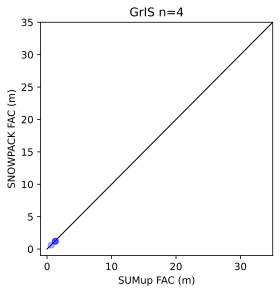

In [7]:
if plot_fac == 'y':
    
    FAC_SU = np.array(FAC_SU)
    FAC_SP = np.array(FAC_SP)
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(4,4.2))
    ax1.set_title(icesheet+' n='+str(len(FAC_SU[FAC_SU>0])))
    ax1.set_xlabel('SUMup FAC (m)')
    ax1.set_ylabel('SNOWPACK FAC (m)')
    ax1.set_xlim((-1,35))
    ax1.set_ylim((-1,35))
    
    ax1.plot((0,35),(0,35),c='k',lw=1,zorder=0)
    ax1.scatter(FAC_SU[FAC_SU>0],FAC_SP[FAC_SU>0],c='b',alpha=0.3)
    
    plt.tight_layout()

In [8]:
# smet_file = path+'VIR'+str(VIR)+'_GrIS.smet'
smet_file = path+'VIR275_GrIS.smet'
smet_header = ['timestamp','Qs','Ql','Qg','TSG','Qg0','Qr','Qmf','CCsnow','OLWR','ILWR','LWR_net','OSWR','ISWR','Qw',
               'pAlbedo','mAlbedo','ISWR_h','ISWR_dir','ISWR_diff','TA','TSS_mod','TSS_meas','T_bottom','RH','VW',
               'VW_drift','DW','MS_Snow','HS_mod','HS_meas','hoar_size','wind_trans24','HN24','HN72_24','SWE','MS_Water',
               'MS_Wind','MS_Rain','MS_SN_Runoff','MS_Soil_Runoff','MS_Sublimation','MS_Evap','MS_melt','MS_freeze',
               'MS_Sublimation_dHS','MS_Settling_dHS','MS_Redeposit_dHS','MS_Redeposit_dRHO','Sclass1','Sclass2','zSd',
               'Sd','zSn','Sn','zSs','Ss','zS4','S4','zS5','S5']

In [9]:
df_smet = pd.read_table(smet_file,skiprows=18,delim_whitespace=True,names=smet_header)
df_smet['timestamp'] = pd.to_datetime(df_smet.timestamp)
df_smet['year'] = df_smet['timestamp'].dt.year
df_smet['month'] = df_smet['timestamp'].dt.month
df_smet.set_index('timestamp',inplace=True)

In [10]:
df_smet_mean = df_smet.resample('Y').mean()
# df_smet_mean.set_index('year',inplace=True)

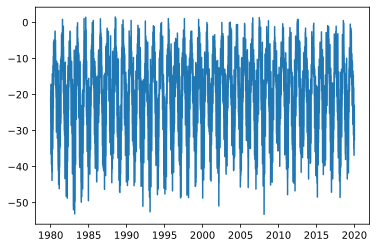

In [13]:
plt.plot(df_smet.TA)
# plt.plot(df_smet_mean.TA)